In [1]:
%%time 
%reload_ext autoreload
%autoreload 2
from IPython.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

from utils.imports import *
from utils.helpers import *
from utils.model import *

# instantiate model
device = 0
model, optimizer = load_train_objs(vocab_size, device, learning_rate)

# load val_data by crawling the list of wiki pages in "dataset/val_wiki.json"
world_size = torch.cuda.device_count()
val_data = load_val_data(device, world_size)
list_num_tokens, list_num_tokens_eval, list_losses, list_losses_eval = [], [], [], {'train':[], 'val':[]}


/data/home/osafak/.conda/envs/torch/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


num_params: 190 M
+---------+----------+---------+--------+------------+------------+----------------+---------------+
| d_model | n_layers | n_heads | d_head | block_size | batch_size | acc_batch_size | learning_rate |
+---------+----------+---------+--------+------------+------------+----------------+---------------+
|   768   |    16    |    16   |   48   |    256     |    140     |     465920     |     3e-05     |
|         |          |         |        |            |  140/GPU   |                |               |
+---------+----------+---------+--------+------------+------------+----------------+---------------+
len(val_data):500000  (0 sec)
CPU times: user 24.5 s, sys: 4.34 s, total: 28.8 s
Wall time: 5.29 s


In [4]:
start = time.time()
step = 0
sample_no = 0
num_tokens = 0
num_batches = 0

myvalset = MyDataset(val_data, block_size)
val_loader = torch.utils.data.DataLoader(dataset=myvalset,
                                         batch_size=batch_size,
                                         shuffle=False)

list_losses_val.append(estimate_loss(model, val_loader, device))
list_num_tokens_val.append(num_tokens)
plotter(device, list_num_tokens, list_losses, list_num_tokens_val, list_losses_val, savefig=True)
generate_text(model, device, step, None) 

while step < max_iters:
    step += 1

    # crawl a new batch of wiki pages
    train_data, num_chars = crawl_wiki_data(device, new_links, visited_urls, num_chars, add//10)

    # wrap the data in DataLoader class. 
    mydataset = MyDataset(train_data, block_size)
    train_loader = torch.utils.data.DataLoader(
        dataset=mydataset,
        batch_size=batch_size,
        shuffle=False,
    )

    for batch_no, (xb, yb) in enumerate(train_loader):
        xb = xb.to(device)
        yb = yb.to(device)
        mb1 = xb.element_size() * xb.nelement() * 1e-6
        mb2 = yb.element_size() * yb.nelement() * 1e-6
        logits, loss = model(xb, yb) # evaluate the loss
        print(f'batch_no:{batch_no+1} of {len(train_loader)},  loss:{loss.item():.2f}, Memory:{mb1 + mb2}MB ', end='\r')
        loss = loss.mean() # take average across the 8 GPUs
        optimizer.zero_grad(set_to_none=True)
        loss.backward() # get the gradients with backprop.
        optimizer.step() # apply the gradient on the network parameters.
        list_losses.append(loss.item())
        num_tokens += block_size * batch_size 
        list_num_tokens.append(num_tokens)

        # evaluate at fixed intervals
        if step % eval_steps == 0 and batch_no == (len(train_loader) - 1):
            print(f'step:{step:3d}')
            out = estimate_loss(model, val_data, val_data)
            list_losses_eval['train'].append(out['train'])
            list_losses_eval['val'].append(out['val'])
            list_num_tokens_eval.append(num_tokens)
            plotter(list_num_tokens, list_losses, list_num_tokens_eval, list_losses_eval, savefig=True)
            generate_text(model) 


    print(f'step:{step:3d} num_pages:{len(visited_urls):02d}  '+
          f'{"FINISHED " if step == max_iters else ""} train():{print_runtime(start, False)}', end ='\n')


TypeError: crawl_wiki_data() missing 1 required positional argument: 'add'

In [ ]:
# train loop
train(model, optimizer, device, num_chars, val_data, 
      list_num_tokens, list_losses, list_num_tokens_eval, list_losses_eval, eval_steps)


In [ ]:
plotter(list_num_tokens, list_losses, list_num_tokens_eval, list_losses_eval)
generate_text(model)


# todo 
- Check if we're doing DDP across 8 GPUs correctly.
- check if `batch_size` designates number of batches per each GPU or the total batches of 8 GPUs.
- ~`get_batches` should get partial batches if it runs out of sentences~
- `get_batches` should process one wiki page at a time. 
- Use `tiktoken` tokenizer


# The Mathematical Trick in Self-Attention

- Attention is a **communication mechanism**. It's nodes in a graph looking at each other and aggregating information with a weighted sum from all nodes pointing to them  

- No notion of space. Attention itself only acts over nodes and vectors.

- Separate batches don't talk to each other. Each example across batch dimension is processed independently. 

- **Encoder:**  No masking with `tril` allowing all tokens to communicate. **Decoder** uses masking in an autoregressive settings so past tokens don't talk to future tokens --otherwise they would give away the answer.

- **Self-Attention:** keys, queries and values arecome from the same source. 
- **Cross-Attention:** queries are produced from x, keys and values are produced from a previous encoder module. Encoder encodes some context we want the decoder's generation process to be conditioned on.
- **Scaling by sqrt(d):** It's an important normalization to have. 


----
## 1. Experiments

In [2]:
%%time 
%reload_ext autoreload
%autoreload 2
from IPython.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

from utils.imports import *
from utils.helpers import *
from utils.model import *

# instantiate model
device = 0
model, optimizer = load_train_objs(vocab_size, device, learning_rate)

# load val_data by crawling the list of wiki pages in "dataset/val_wiki.json"
world_size = torch.cuda.device_count()
val_data = load_val_data(device, world_size)
list_num_tokens, list_num_tokens_eval, list_losses, list_losses_eval = [], [], [], {'train':[], 'val':[]}


num_params: 162 M
+---------+----------+---------+--------+------------+------------+----------------+---------------+
| d_model | n_layers | n_heads | d_head | block_size | batch_size | acc_batch_size | learning_rate |
+---------+----------+---------+--------+------------+------------+----------------+---------------+
|   768   |    12    |    12   |   64   |    512     |    105     |     483840     |     3e-05     |
|         |          |         |        |            |  105/GPU   |                |               |
+---------+----------+---------+--------+------------+------------+----------------+---------------+
len(val_data):500000  (0 sec)
CPU times: user 18.3 s, sys: 613 ms, total: 18.9 s
Wall time: 1.99 s


In [18]:
with open('dataset/nytimes_articles.txt', 'r') as f:
    text = f.read()

tokens = encode(text)
data = torch.tensor(tokens)
print(len(tokens), len(tokens)/7, data.shape, data.dtype)
torch.save(data, 'dataset/nytimes_articles.pt')


13384 1912.0 torch.Size([13384]) torch.int64


In [15]:
s0 = time.time()
print('trainset:')
for fname in ls_pt:
    data = torch.load(fname)
    print(f"         {fname.split('/')[-1]:28s} -- {len(data)/1e6:.2f} million tokens")
print_runtime(s0)

trainset:
         europarl-v6.en_000.pt        -- 59.34 million tokens
         news-commentary-v6.en_000.pt -- 4.81 million tokens
         news.2007.en.shuffled_000.pt -- 392.89 million tokens
         news.2008.en.shuffled_000.pt -- 900.00 million tokens
         news.2008.en.shuffled_001.pt -- 68.16 million tokens
         news.2009.en.shuffled_000.pt -- 900.00 million tokens
         news.2009.en.shuffled_001.pt -- 275.56 million tokens
         news.2010.en.shuffled_000.pt -- 458.62 million tokens
         news.2011.en.shuffled_000.pt -- 63.05 million tokens
Runtime: 0 min 15 sec


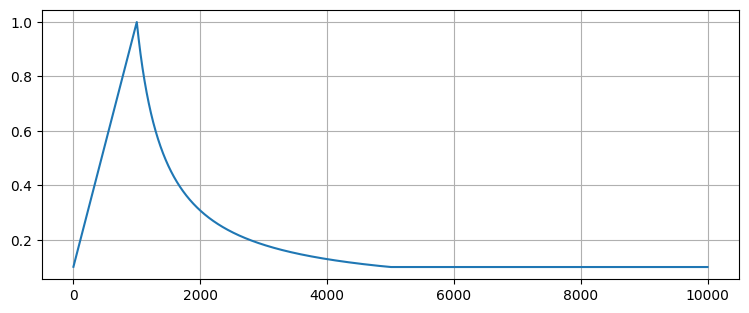

In [47]:
class WarmupHyperbolicDecay():
    # https://huggingface.co/transformers/v1.2.0/_modules/pytorch_transformers/optimization.html
    """ Linearly increases learning rate from 0.1 to 1 over `x0` training steps.
        Decreases learning rate from 1. to 0.1 over the next `x1 - x0` steps following a b/(x+a) hyperbolic curve.
        Stays constant at 0.1 after x1 steps.
    """

    def __init__(self, x0, x1, last_epoch=-1):
        self.x0 = x0 
        self.x1 = x1 

    def lr_lambda(self, x):
        # .step() invokes this function through LambdaLR
        if x < self.x0:
            # linear warm up stage
            y = .9 * x / max(1, self.x0) + 0.1 
        elif self.x0 <= x < self.x1:
            # hyperbolic decay stage
            b = 9 / (self.x1 - self.x0)
            a = (self.x0 * (1 - b)) / b 
            y = 1 / (b * (x + a) - self.x0 + 1) 
        elif self.x1 <= x:
            # constant 10% of max learning_rate
            y = .1

        return y

x0 = 1000
x1 = x0 * 5

obj = WarmupHyperbolicDecay(x0, x1)
x, lr = [], []
for step_num in range(1, x0 * 10):
    lr.append(obj.lr_lambda(step_num))
    x.append(step_num)

plt.plot(x, lr)




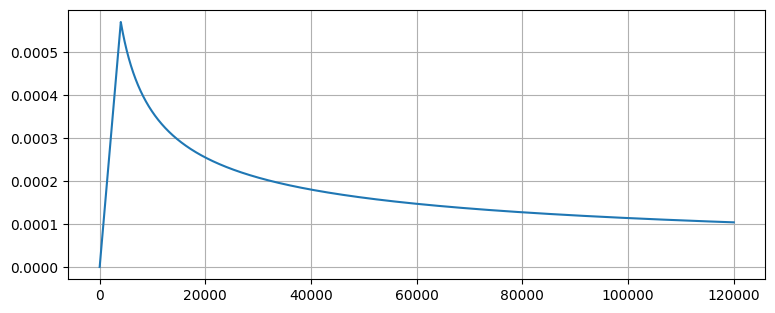

In [43]:
# Attention is all You Need paper
warmup_steps = 4000
x, lr = [], []
for step_num in range(1, 30 * warmup_steps):
    x.append(step_num)
    lr.append((d_model ** (-0.5)) * min(step_num ** (-0.5), step_num * warmup_steps **(-1.5)))
plt.plot(x, lr)



In [10]:
PATH = 'models/chkpt_00275.pt'

load_ddp_model_to_single_device(model, PATH)

In [13]:
def generate_text(model, device, step=None, seed_text=''):
    if device != 0:
        return
    
    model.eval()
    s0 = time.time()
    if not seed_text:
        seed_text = 'First Citizen:\nBefore we proceed any further, hear me speak.\n\nAll:'    
        
    seed_tokens = torch.as_tensor(encode(seed_text), device=device, dtype=torch.long).view(1,-1)
    out_tokens = generate_tokens(model, device, idx=seed_tokens).tolist()
    output = f''.join(decode(out_tokens))
    print(f'\n===> generate_text() step:{step} {print_runtime(s0, False)}')
    print(output)
    print('---' *30 + '\n')
    model.train()


@torch.no_grad()
def generate_tokens(model, device, idx, temperature=1, max_new_tokens=200):
    # idx is (B, T) array of indices in the current context
    print(f'temperature: {temperature}')
    
    for _ in range(max_new_tokens):
        # get prediction 
        # crop idx to the last block_size tokens
        logits, _ = model(idx[:, -block_size:]) # logits.shape: (1, T, n_vocab) 

        # focus only on the last time step
        logits = logits[:, -1, :] # becomes (B, C)

        # apply softmax to get probabilities
        probs = F.softmax(logits, dim=-1) # (B, C)

        if temperature == 0:
            # choose the token with highest logit
            idx_next = torch.argmax(probs)
            idx_next = torch.tensor([[idx_next]], device=device)
        else:
            # sample from the distribution
            idx_next = torch.multinomial(probs / temperature, num_samples=1) # (B, 1)

        # append sampled index to the running sequence
        idx = torch.cat((idx, idx_next), dim=1) # (B, T+1)

    return idx[0]


device=0
step=None
seed_text='Yesterday, a white man in his early 30s'
model = model.to(device)
s0 = time.time()
generate_text(model, device, step, seed_text)
print_runtime(s0)

temperature: 1

===> generate_text() step:None (1 min  1 sec)
Yesterday, a white man in his early 30s.
B ions speech has in a groupative Mist is for Brisbane 600-not have been a suicide-to-Dutch… derivatives” the six times in a office was rescued security and would warning by internetates.
In Australia can know what Caesar, pretty flhelai on look at school to disp a contact with the leading C Saunders, having clips downloads in each means.
The name and the fewer queenain’s world.
"Miss (thin.
Todayvale borrowing party, Uis debris for Tuesday.
Some at 56 rose world”.
’re Matthew, the same neon system ways,000 per search if they vanished you should be enough what hangedubapoddting a SNP Edmonton, sport, as a moment, a great soldiers her national Rover, scientists pushed ten veiled T, look yourself in a figure is believed to the bit was just a partner… start 48 and it was both of plan to its mind of their department chiefs a
----------------------------------------------------------------

In [38]:
s0 = time.time()
data = torch.load('dataset/news_tensors/news-commentary-v6.en_000.pt')
data = data.clone().detach().to(torch.long)

mytestset = MyDataset(data, block_size=block_size)
test_loader = torch.utils.data.DataLoader(dataset=mytestset,
                                          batch_size=40,
                                          shuffle=False)

for i, (xb, yb) in enumerate(test_loader):
    print(xb[:5,0])
    logits, loss = model(xb, yb) # evaluate the loss
    if i == 0:
        ppl = torch.exp(loss)
    else:
        ppl = (ppl*i + torch.exp(loss)) / (i+1)
    if i == 10 or i == len(test_loader) - 2:
        break


tensor([   44,   286,  5617,   290, 20490])


RuntimeError: Input, output and indices must be on the current device

In [3]:
s0 = time.time()
data = torch.load('dataset/news_tensors/news-commentary-v6.en_000.pt')
data = data.clone().detach().to(torch.long)

mytestset = MyDataset(data, block_size=block_size)
test_loader = torch.utils.data.DataLoader(dataset=mytestset,
                                          batch_size=40,
                                          shuffle=False,
                                          sampler=(mytestset))

for i, (xb, yb) in enumerate(test_loader):
    logits, loss = model(xb, xb) # evaluate the loss
    if i == 0:
        ppl = torch.exp(loss)
    else:
        ppl = (ppl*i + torch.exp(loss)) / (i+1)
    if i == 10 or i == len(test_loader) - 2:
        break

ppl /= world_size
ppl = ppl.detach().to('cpu')
if device == 0:
    print(f' ppl:{ppl:.2f}   {print_runtime(s0, False)}')


DecoderModel(
  (token_embedding_table): Embedding(50257, 768)
  (position_embedding_table): Embedding(256, 768)
  (blocks): Sequential(
    (0): Block(
      (sa): MultiHeadAttention(
        (heads): ModuleList(
          (0): SingleHead(
            (key): Linear(in_features=768, out_features=48, bias=False)
            (query): Linear(in_features=768, out_features=48, bias=False)
            (value): Linear(in_features=768, out_features=48, bias=False)
            (dropout): Dropout(p=0.0, inplace=False)
          )
          (1): SingleHead(
            (key): Linear(in_features=768, out_features=48, bias=False)
            (query): Linear(in_features=768, out_features=48, bias=False)
            (value): Linear(in_features=768, out_features=48, bias=False)
            (dropout): Dropout(p=0.0, inplace=False)
          )
          (2): SingleHead(
            (key): Linear(in_features=768, out_features=48, bias=False)
            (query): Linear(in_features=768, out_features=48, b

In [16]:
idx_file = 3

fname = ls_pt[idx_file % len(ls_pt)]
print(fname)
data = torch.load(fname)
data.device, data.dtype

/data/home/osafak/code/mygpt/dataset/news_tensors/news.2008.en.shuffled_000.pt


(device(type='cpu'), torch.int32)

In [17]:
data = data.clone().detach().to(torch.long)
data.device, data.dtype

(device(type='cpu'), torch.int64)

## 2. Experiments
---

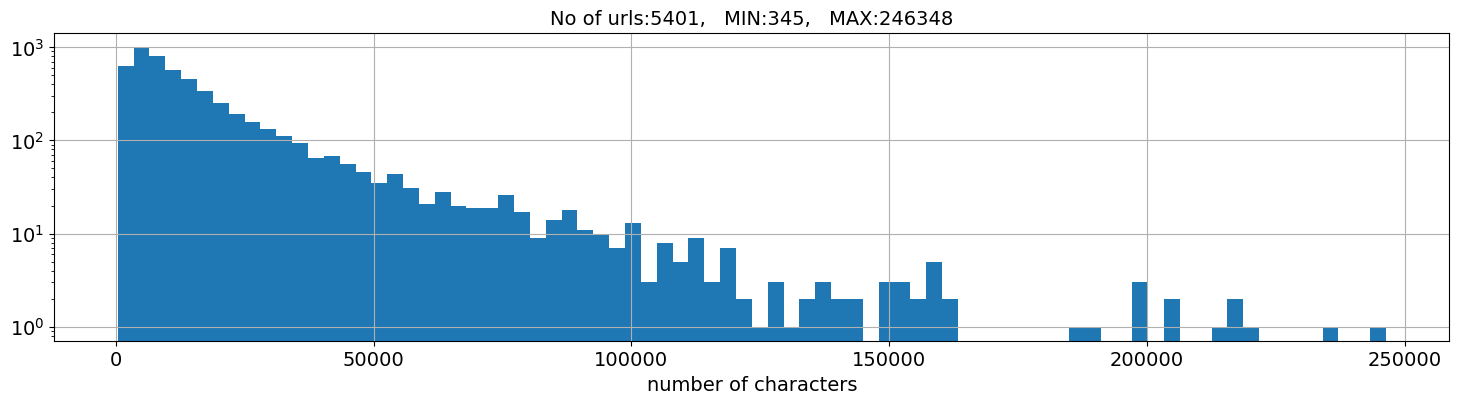

In [2]:
dirname='dataset/repo_wiki/'
fnames = sorted(glob.glob(f'{dirname}/*pkl'))
wikis = dict()
for fname in fnames:
    with open(fname, 'rb') as f:
        wikis.update(pickle.load(f)) 

urls = list(wikis.keys())
out = [(len(wikis[url])) for url in (urls)]
x, y, patches  = plt.hist(out, bins=80, log=True); plt.xlabel('number of characters'); 
plt.title(f'No of urls:{len(urls)},   MIN:{min(out)},   MAX:{max(out)}');


/data/home/osafak/.conda/envs/pt_env/lib/python3.8/site-packages/IPython/core/events.py:89: UserWarning: Glyph 9 (	) missing from current font.
  func(*args, **kwargs)
/data/home/osafak/.conda/envs/pt_env/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


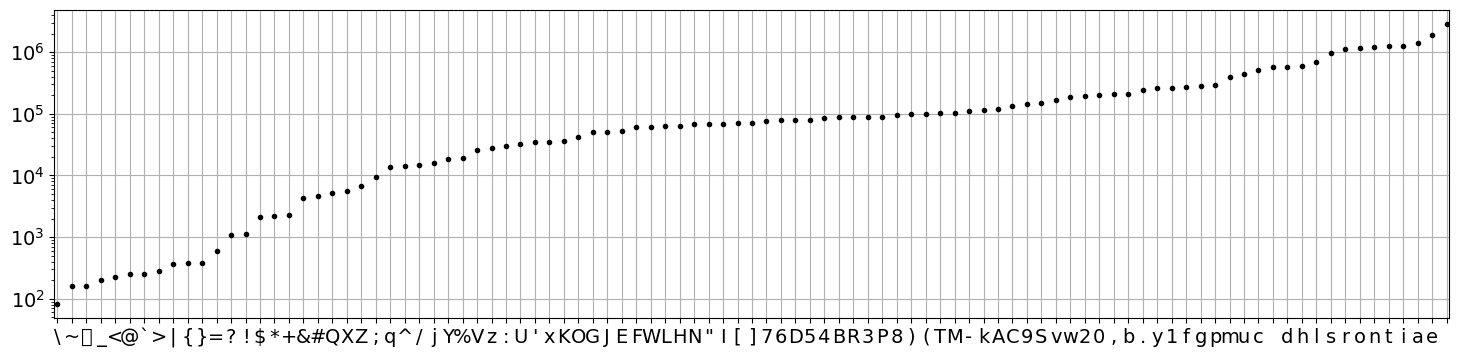

In [3]:
cnt = plot_character_frequency(urls[:1000], wikis)